# AdventureWorks Försäljningsanalys
I denna analys undersöker jag AdventureWorks-databasen för att besvara affärsfrågor som exempelvis:
- Produktkategorier och deras försäljning
- Försäljningstrender över tid
- Regional försäljning

Jag använder SQL för att hämta data och Python för visualisering och analys

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.legend_handler import HandlerTuple
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("Password123")
server = 'localhost:1433'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 17 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\Kevin\AppData\Local\Temp\ipykernel_24244\653054087.py:24: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [2]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

## Visualisering 1: Antal produkter per kategori

### Affärsfråga
Hur många produkter finns i varje kategori?

### Använda tabeller
- Production.ProductCategory  
- Production.ProductSubcategory  
- Production.Product  

### Metod
- Tabellerna sammanfogas med hjälp av JOINs
- Antal **unika produkter** räknas per kategori
- Resultatet visualiseras med ett **vertikalt stapeldiagram**
- Analysera resultatet

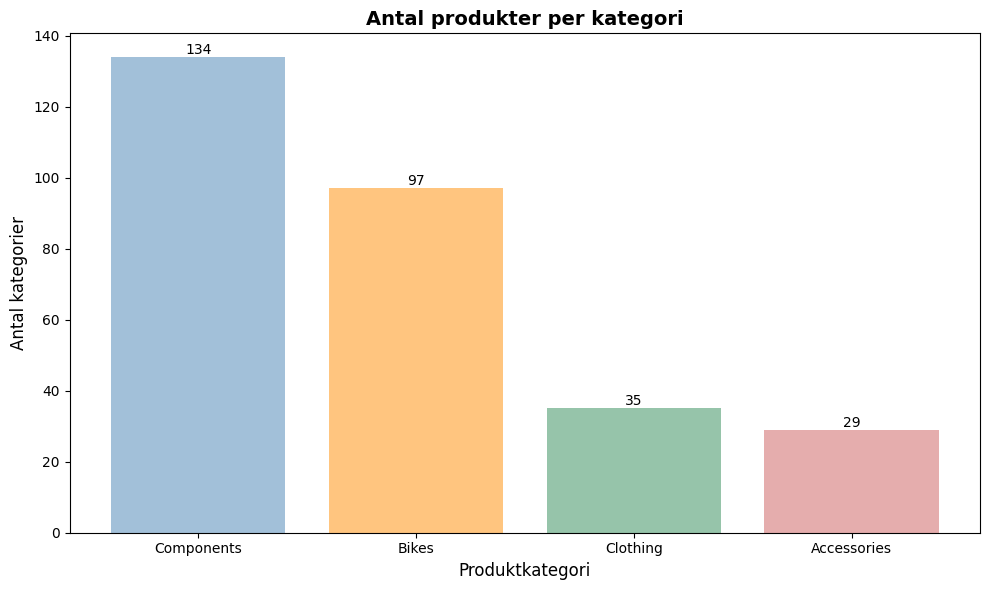

In [3]:
query_vis1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount

FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis1 = query_df(query_vis1)

fig, ax = plt.subplots(figsize=(10,6))

colors = [
    'steelblue', 'darkorange',
    'seagreen','indianred'
]

bars = ax.bar(
    df_vis1['CategoryName'],
    df_vis1['ProductCount'],
    color=colors[:len(df_vis1)], alpha=0.5
    )

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )
    

ax.set_xlabel('Produktkategori', fontsize=12)
ax.set_ylabel('Antal kategorier', fontsize=12)
ax.set_title('Antal produkter per kategori', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### Insikter - antal produkter per kategori
Components är största kategori med 134 produkter.
Accessories är minst med 29 produkter.

Detta indikerar på att företaget är starkt fokuserat på komponenter och reservdelar.
Samt att accessories kan vara ett utvecklingsområde.

## Visualisering 2: Total försäljning per produktkategori

### Affärsfråga
Vilka produktkategorier genererar mest intäkter?

### Använda tabeller
- Production.ProductCategory  
- Production.ProductSubcategory  
- Production.Product  
- Sales.SalesOrderDetail  

### Metod
- Tabellerna sammanfogas med JOINs
- Total försäljning beräknas per kategori
- Resultatet sorteras från högst till lägst
- Visualiseras med ett **horisontellt stapeldiagram**

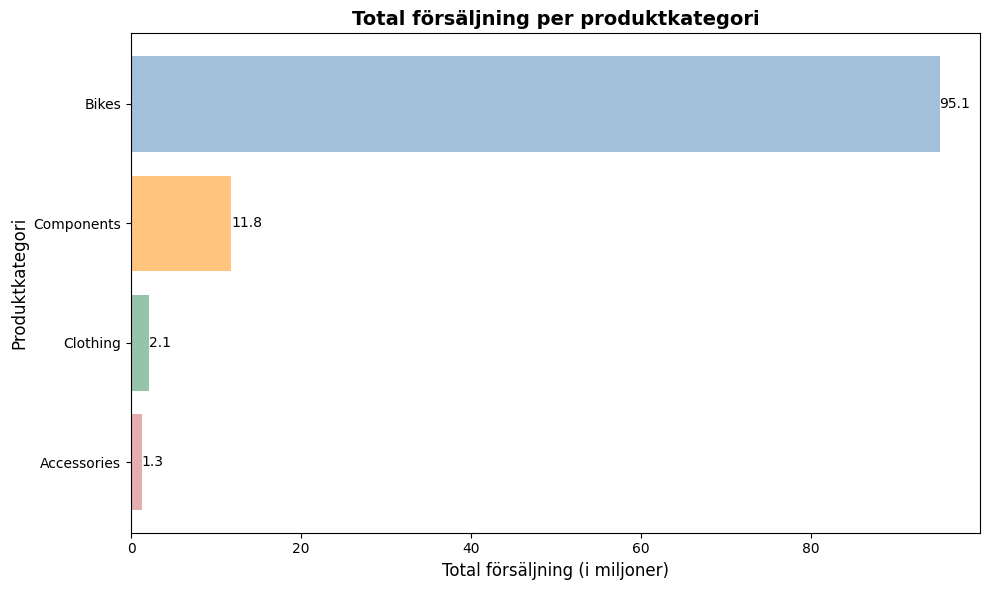

In [4]:
query_vis2 = """
SELECT
    pc.Name AS CategoryName,
    SUM(sod.OrderQty * sod.UnitPrice) AS TotalSales
FROM Production.ProductCategory pc

INNER JOIN Production.ProductSubcategory psc
    ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p
    ON psc.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail sod
    ON p.ProductID = sod.ProductID
GROUP BY pc.Name
ORDER BY TotalSales DESC
"""

df_vis2 = query_df(query_vis2)

df_vis2['TotalSales_M'] = df_vis2['TotalSales'] / 1_000_000

fig, ax = plt.subplots(figsize=(10,6))

bars = ax.barh(
    df_vis2['CategoryName'],
    df_vis2['TotalSales_M'],
    color=colors[:len(df_vis2)], alpha=0.5
)

for bar in bars:
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height()/2,
        f'{width:.1f}',
        va='center',
        ha='left'
    )

ax.set_xlabel('Total försäljning (i miljoner)', fontsize=12)
ax.set_ylabel('Produktkategori', fontsize=12)
ax.set_title('Total försäljning per produktkategori', fontsize=14, fontweight='bold')

ax.invert_yaxis()
plt.tight_layout()
plt.show()

### Insikter – total försäljning per produktkategori

Det är tydligt att **Bikes** dominerar försäljningen och står för cirka **95,1 miljoner**, vilket gör detta till företagets absolut största produktkategori sett till intäkter.

I andra änden ligger **Accessories**, som endast når omkring **1,3 miljoner** i försäljning. Det visar att denna kategori spelar en betydligt mindre roll för den totala försäljningen jämfört med de övriga kategorierna.

Försäljningsvärdena har beräknats som **OrderQty * UnitPrice**.

## Visualisering 3: Försäljningstrend över tid

### Affärsfråga
Hur har försäljningen utvecklats över tid?

### Använda tabeller
- Sales.SalesOrderHeader

### Metod
- Försäljning aggregeras per månad baserat på orderdatum
- Resultatet sorteras kronologiskt, från äldsta till senaste månad
- Visualiseras med ett linjediagram för att tydligt visa trenden över tid

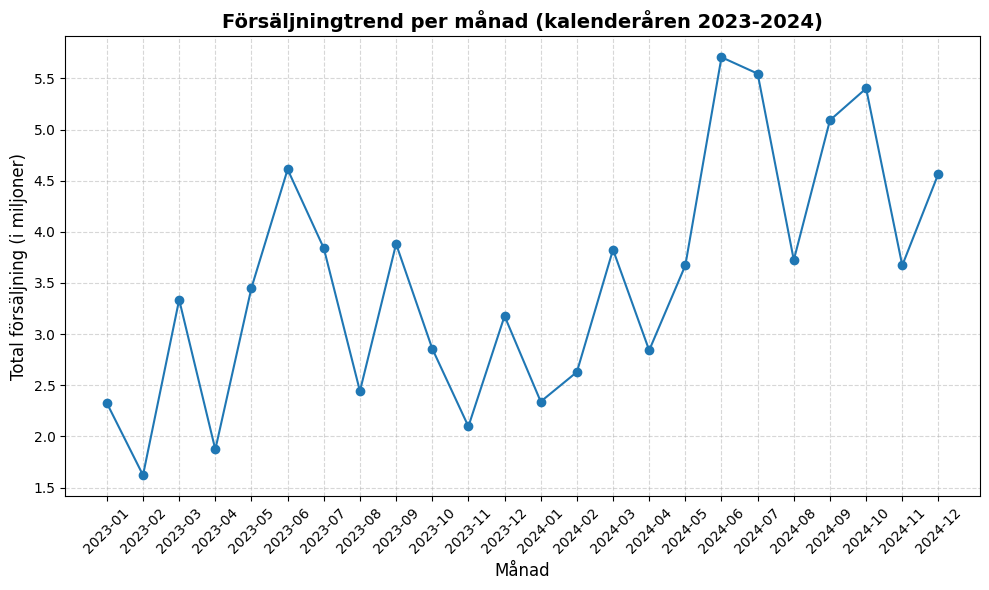

Bästa månad: 2024-06: 5.71 miljoner
Sämsta månad: 2023-02: 1.62 miljoner


In [5]:
query_vis3 = """
SELECT
    FORMAT(OrderDate, 'yyyy-MM') AS YearMonth,
    SUM(TotalDue) AS TotalSales

FROM Sales.SalesOrderHeader
WHERE OrderDate >= '2023-01-01'
AND OrderDate < '2025-01-01'
GROUP BY FORMAT(OrderDate, 'yyyy-MM')
ORDER BY YearMonth ASC
"""

df_vis3 = query_df(query_vis3)

df_vis3['TotalSales_M'] = df_vis3['TotalSales'] / 1_000_000
best_month = df_vis3.loc[df_vis3['TotalSales_M'].idxmax()]
worst_month = df_vis3.loc[df_vis3['TotalSales_M'].idxmin()]

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(
    df_vis3['YearMonth'],
    df_vis3['TotalSales_M'],
    marker='o'
)

ax.set_title('Försäljningtrend per månad (kalenderåren 2023-2024)', fontsize=14, fontweight='bold')
ax.set_xlabel('Månad', fontsize=12)
ax.set_ylabel('Total försäljning (i miljoner)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(
    f"Bästa månad: {best_month['YearMonth']}: "
    f"{best_month['TotalSales_M']:.2f} miljoner"
)

print(
    f"Sämsta månad: {worst_month['YearMonth']}: "
    f"{worst_month['TotalSales_M']:.2f} miljoner"
)

### Insikter – försäljningstrend över tid

Försäljningen varierar tydligt över året och följer ett återkommande mönster. Under våren, särskilt runt april och maj, ökar försäljningen markant. Under sommaren avtar försäljningen gradvis och når en lägre nivå mot sensommaren, runt augusti, innan den ökar igen under september.

Den bästa månaden under perioden är **juni 2024** med cirka **5,71 miljoner** i försäljning, medan den svagaste månaden är **februari 2023** med omkring **1,62 miljoner**. Sammantaget tyder detta på att försäljningen är säsongsbetonad snarare än jämnt fördelad över året.

Utöver säsongsmönstret ligger försäljningsnivåerna generellt något högre under 2024 jämfört med 2023, vilket kan tyda på en positiv utveckling över tid.

## Visualisering 4: Försäljning och antal ordrar per år

### Affärsfråga
Hur ser total försäljning och antal ordrar ut per år?

### Använda tabeller
- Sales.SalesOrderHeader

### Metod
- Försäljning och antal ordrar aggregeras per år
- Resultatet sorteras kronologiskt
- Visualiseras med två stapeldiagram för att möjliggöra jämförelse mellan åren

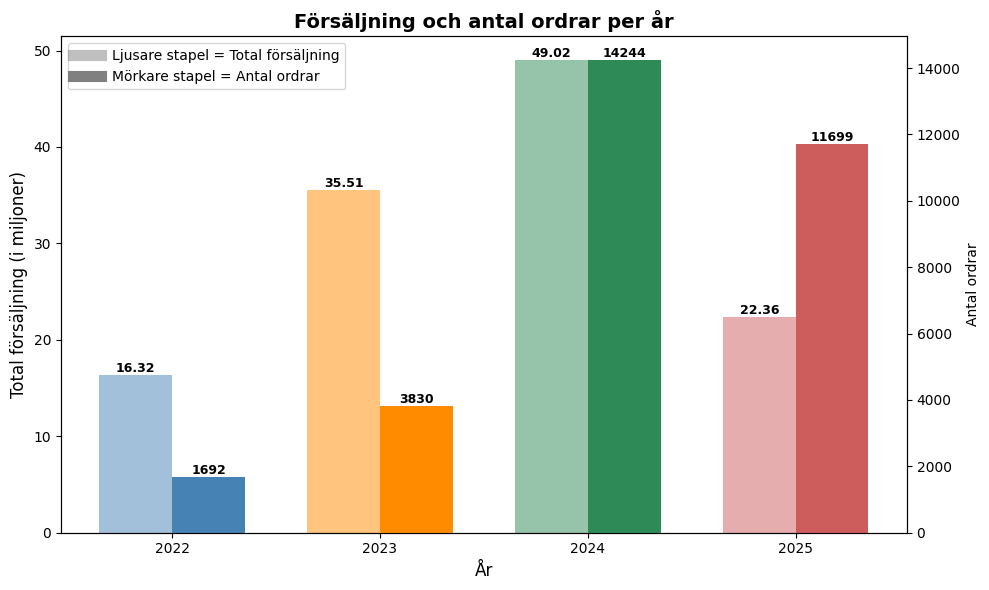

In [6]:
query_vis4 = """
SELECT
    YEAR(OrderDate) AS OrderYear,
    SUM(TotalDue) AS TotalSales,
    COUNT(SalesOrderId) AS OrderCount

FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY OrderYear ASC
"""

df_vis4 = query_df(query_vis4)

df_vis4['TotalSales_M'] = df_vis4['TotalSales'] / 1_000_000

years = df_vis4['OrderYear']
x = np.arange(len(years))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10,6))

bars_sales = ax1.bar(
    x - width/2,
    df_vis4['TotalSales_M'],
    width,
    color=colors[:len(df_vis4)],
    alpha=0.5
)

for bar in bars_sales:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{height:.2f}',
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold'
    )

ax1.set_title('Försäljning och antal ordrar per år', fontsize=14, fontweight='bold')
ax1.set_xlabel('År', fontsize=12)
ax1.set_ylabel('Total försäljning (i miljoner)', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(years)

ax2 = ax1.twinx()

bars_orders = ax2.bar(
    x + width/2,
    df_vis4['OrderCount'],
    width,
    color=colors[:len(df_vis4)],
    alpha=1
)

for bar in bars_orders:
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold'
    )

ax2.set_ylabel('Antal ordrar')

ax1.plot([], [], color='grey', alpha=0.5, linewidth=8,
         label='Ljusare stapel = Total försäljning')

ax1.plot([], [], color='grey', alpha=1.0, linewidth=8,
         label='Mörkare stapel = Antal ordrar')

ax1.legend(loc='upper left')

plt.tight_layout()
plt.show()

### Insikter – försäljning och antal ordrar per år

Vid en jämförelse mellan åren är det viktigt att notera att **2023** och **2024** är de enda fullständiga kalenderåren i datamaterialet och därför mest relevanta att jämföra.

Mellan **2023** och **2024** syns en kraftig ökning i antalet ordrar, medan den totala försäljningen ökar i mer begränsad omfattning – från cirka **35,5 miljoner** till **49 miljoner**. Detta tyder på att tillväxten i första hand drivs av fler genomförda köp snarare än en motsvarande ökning i genomsnittligt ordervärde.

Åren **2022** och **2025** innehåller endast delar av året (**8** respektive **6** månader) och bör därför tolkas med försiktighet. Den lägre nivån för dessa år speglar sannolikt datatäckningen snarare än en faktisk förändring i försäljningsutvecklingen.

Sammanfattningsvis är **2024** det år med högst total försäljning, och jämfört med 2023 ökar både försäljning och antal ordrar, även om ökningen är betydligt starkare för antal ordrar än för försäljningen i sig.

## Visualisering 5: Top 10 produkter efter försäljning

### Affärsfråga
Vilka 10 produkter genererar mest försäljning?

### Använda tabeller
- Production.Product  
- Sales.SalesOrderDetail  

### Metod
- Försäljning beräknas per produkt
- Produkterna sorteras från högst till lägst försäljning
- Endast de 10 mest säljande produkterna visas
- Resultatet visualiseras med ett horisontellt stapeldiagram

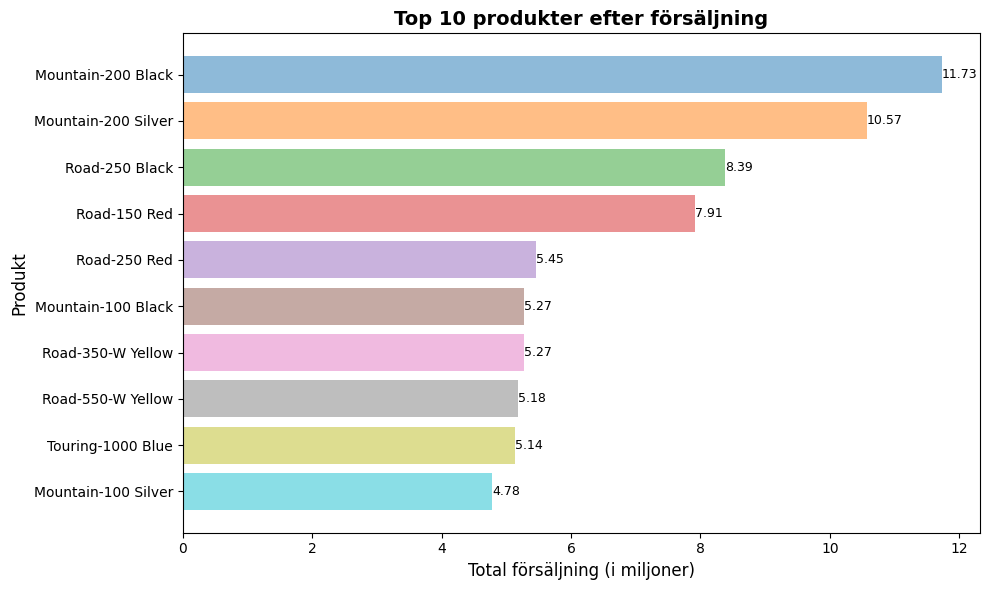

#1 produkt : Mountain-200 Black - total försäljning : 11,731,317.50
Dominanta kategorin är: Bikes


In [7]:
query_vis5 = """
SELECT TOP 10
    LEFT(p.Name, CHARINDEX(',', p.Name + ',') - 1) AS ProductModel,
    pc.Name AS CategoryName,
    SUM(sod.OrderQty * sod.UnitPrice) AS TotalSales

FROM Sales.SalesOrderDetail sod
INNER JOIN Production.Product p
    ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductSubcategory psc
    ON p.ProductSubcategoryID = psc.ProductSubcategoryID
INNER JOIN Production.ProductCategory pc
    ON psc.ProductCategoryID = pc.ProductCategoryID
GROUP BY
    LEFT(p.Name, CHARINDEX(',', p.Name + ',') - 1),
    pc.Name
ORDER BY TotalSales DESC;
"""

df_vis5 = query_df(query_vis5)

df_vis5['TotalSales_M'] = df_vis5['TotalSales'] / 1_000_000

colors = plt.cm.tab10(np.arange(len(df_vis5)))

fig, ax = plt.subplots(figsize=(10,6))

bars = ax.barh(
    df_vis5['ProductModel'],
    df_vis5['TotalSales_M'],
    color=colors,
    alpha=0.5
)

for bar in bars:
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height()/2,
        f'{width:.2f}',
        va='center',
        ha='left',
        fontsize=9
    )

ax.set_title('Top 10 produkter efter försäljning', fontsize=14, fontweight='bold')
ax.set_xlabel('Total försäljning (i miljoner)', fontsize=12)
ax.set_ylabel('Produkt', fontsize=12)

ax.invert_yaxis()

plt.tight_layout()
plt.show()

top1 = df_vis5.iloc[0]
top1_model = top1['ProductModel']
top1_sales = top1['TotalSales']

category_counts = df_vis5['CategoryName'].value_counts()
dominant_category = category_counts.index[0]

print(
    f'#1 produkt : {top1_model} - '
    f'total försäljning : {top1_sales:,.2f}'
)

print(
    f'Dominanta kategorin är: {dominant_category}'
)

### Insikter – top 10 produkter efter försäljning

Den mest säljande produkten är **Mountain-200 Black**, med en total försäljning på **11,731,317.50**.

Topp 10-listan domineras av kategorin **Bikes**, vilket tyder på att denna kategori innehåller företagets mest intäktsdrivande produkter.

Försäljningen har aggregerats på produktmodellnivå genom att slå ihop olika storleksvarianter, för att ge en mer rättvis bild av vilka produkter som genererar mest försäljning.

## Visualisering 6: Försäljning och antal kunder per region

### Affärsfråga
Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?

### Använda tabeller
- Sales.SalesTerritory  
- Sales.SalesOrderHeader  
- Sales.Customer  

### Metod
- Försäljning summeras per region
- Antal unika kunder räknas per region
- Regionerna sorteras från högst till lägst försäljning
- Resultatet visualiseras med ett grupperat stapeldiagram

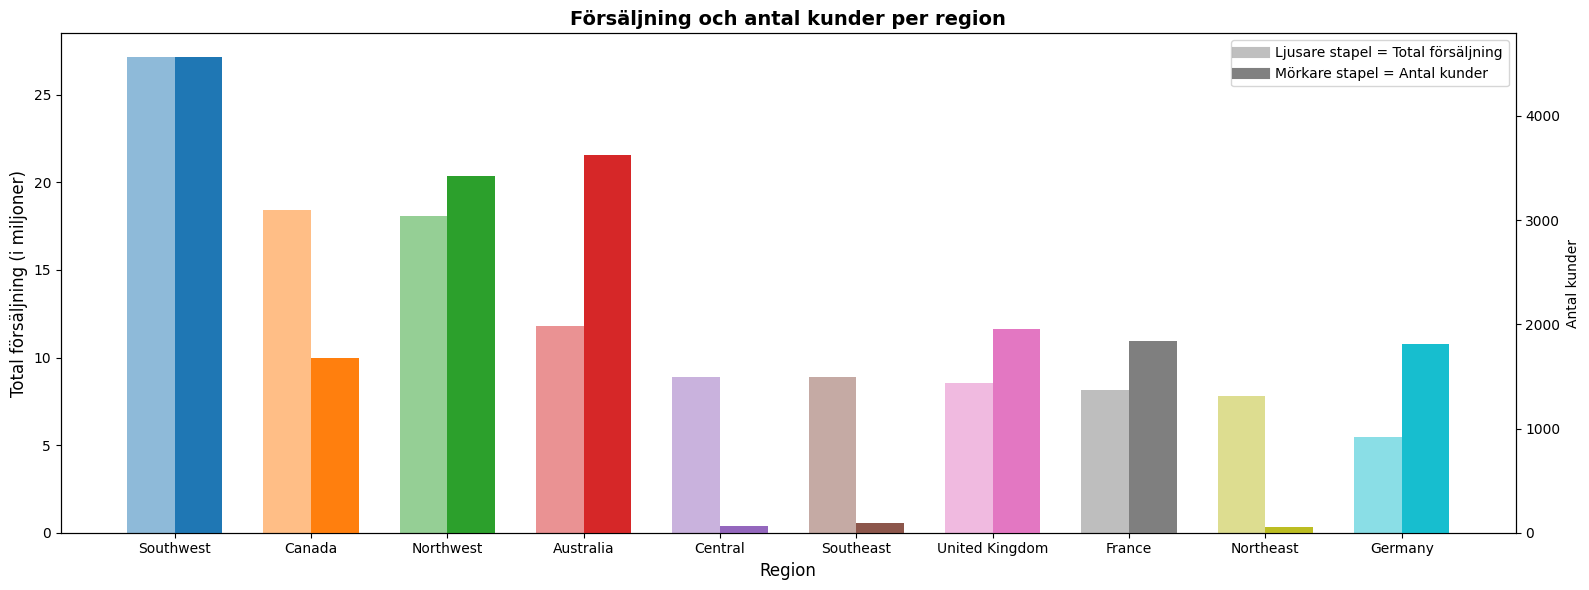

In [8]:
query_vis6 = """
SELECT
    st.Name AS Region,
    SUM(soh.TotalDue) AS TotalSales,
    COUNT(DISTINCT c.CustomerID) AS CustomerCount

FROM Sales.SalesOrderHeader soh
INNER JOIN Sales.SalesTerritory st
    ON soh.TerritoryID = st.TerritoryID
INNER JOIN Sales.Customer c
    ON soh.CustomerID = c.CustomerID
GROUP BY st.Name
ORDER BY TotalSales DESC
"""

df_vis6 = query_df(query_vis6)

df_vis6['TotalSales_M'] = df_vis6['TotalSales'] / 1_000_000

regions = df_vis6['Region']
x = np.arange(len(regions))
width = 0.35

fig, ax1 = plt.subplots(figsize=(16,6))

bars_sales = ax1.bar(
    x - width/2,
    df_vis6['TotalSales_M'],
    width,
    color=colors,
    alpha=0.5
)

ax1.set_title('Försäljning och antal kunder per region', fontsize=14, fontweight='bold')
ax1.set_xlabel('Region', fontsize=12)
ax1.set_ylabel('Total försäljning (i miljoner)', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(regions)

ax2 = ax1.twinx()

bars_customers = ax2.bar(
    x + width/2,
    df_vis6['CustomerCount'],
    width,
    label='Antal kunder',
    color=colors,
    alpha=1
)

ax2.set_ylabel('Antal kunder')

ax1.plot([], [], color='gray', alpha=0.5, linewidth=8,
         label='Ljusare stapel = Total försäljning')
ax1.plot([], [], color='gray', alpha=1.0, linewidth=8,
         label='Mörkare stapel = Antal kunder')

ax1.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Insikter – försäljning och antal kunder per region

Regionen **Southwest** är den starkaste regionen sett till total försäljning, med cirka **27,2 miljoner**, och har även det högsta antalet kunder (**4 565**). Detta tyder på att försäljningen i regionen till stor del drivs av en stor kundbas.

I den andra änden återfinns regionen **Germany**, som har den lägsta försäljningen med cirka **5,5 miljoner**, trots att antalet kunder (**1 812**) är relativt högt jämfört med flera andra regioner. Detta indikerar ett lägre genomsnittligt ordervärde per kund i denna region.

Jämförelsen mellan regionerna visar att hög försäljning inte enbart beror på många kunder. Exempelvis har **Central**, **Southeast** och **Northeast** mycket få kunder men ändå en relativt hög total försäljning, vilket tyder på att dessa regioner kännetecknas av färre men mer värdefulla kunder med högre ordervärde per kund.

## Visualisering 7: Genomsnittligt ordervärde per region och kundtyp

### Affärsfråga
Vilka regioner har högst respektive lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?

### Använda tabeller
- Sales.SalesTerritory  
- Sales.SalesOrderHeader  
- Sales.Customer  
- Sales.Store  

### Metod
- Genomsnittligt ordervärde beräknas som total försäljning dividerat med antal ordrar
- Kunder delas upp i företagskunder (Store) och privatpersoner (Individual)
- Resultatet grupperas per region och kundtyp
- Regionerna sorteras efter högst genomsnittligt ordervärde

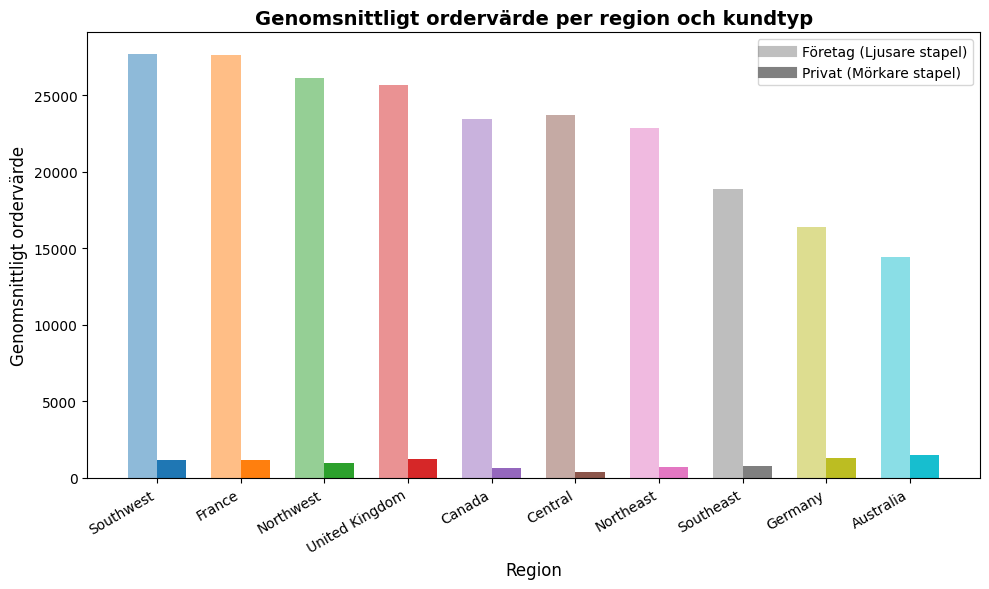

In [9]:
query_vis7 = """
SELECT
    st.Name AS Region,
    CASE
        WHEN c.StoreID IS NOT NULL THEN 'Store'
        WHEN c.PersonID IS NOT NULL THEN 'Individual'
        ELSE 'Unknown Customer Type'
    END AS CustomerType,
    SUM(soh.TotalDue) / COUNT(soh.SalesOrderID) AS AvgOrderValue
FROM Sales.SalesOrderHeader soh
INNER JOIN Sales.SalesTerritory st
    ON soh.TerritoryID = st.TerritoryID
INNER JOIN Sales.Customer c
    ON soh.CustomerID = c.CustomerID
GROUP BY
    st.Name,
    CASE
        WHEN c.StoreID IS NOT NULL THEN 'Store'
        WHEN c.PersonID IS NOT NULL THEN 'Individual'
        ELSE 'Unknown Customer Type'
    END
ORDER BY
    AvgOrderValue DESC
"""

df_vis7 = query_df(query_vis7)

df_pivot = df_vis7.pivot(
    index='Region',
    columns='CustomerType',
    values='AvgOrderValue'
)

df_pivot['TotalAvg'] = df_pivot.mean(axis=1)
df_pivot = df_pivot.sort_values('TotalAvg', ascending=False)

regions = df_pivot.index
x = np.arange(len(regions))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))

bars_store = ax.bar(
    x - width/2,
    df_pivot['Store'],
    width,
    color=colors[:len(df_pivot)],
    alpha=0.5
)

bars_individual = ax.bar(
    x + width/2,
    df_pivot['Individual'],
    width,
    color=colors[:len(df_pivot)],
    alpha=1
)

ax.set_title('Genomsnittligt ordervärde per region och kundtyp', fontsize=14, fontweight='bold')
ax.set_xlabel('Region', fontsize=12)
ax.set_ylabel('Genomsnittligt ordervärde', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(regions, rotation=30, ha='right')

ax.plot([], [], color='gray', alpha=0.5, linewidth=8,
        label='Företag (Ljusare stapel)')

ax.plot([], [], color='gray', alpha=1.0, linewidth=8,
        label='Privat (Mörkare stapel)')

ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

### Insikter – genomsnittligt ordervärde per region och kundtyp

Analysen visar att **företagskunder** har ett betydligt högre genomsnittligt ordervärde än **privatkunder** i samtliga regioner. Detta är väntat då företagskunder ofta genomför större och mer omfattande inköp per order.

Skillnaderna mellan kundtyper är tydliga i alla regioner, men varierar i storlek. Exempelvis har **Southwest** och **France** mycket höga genomsnittliga ordervärden för företagskunder, medan motsvarande värden för privatkunder ligger avsevärt lägre. Detta indikerar att försäljningen i dessa regioner till stor del drivs av färre men större affärer inom företagssegmentet.

Den högsta genomsnittliga ordernivån återfinns hos **företagskunder i Southwest**, med ett genomsnittligt ordervärde på **27 739**. Den lägsta återfinns hos **privatkunder i Central**, med ett genomsnitt på **368**. Sammantaget visar analysen att både region och kundtyp har stor påverkan på hur stort ordervärdet i genomsnitt blir.

## Sammanfattning

### Huvudsakliga fynd
- Försäljningen domineras av produktkategorin Bikes, både sett till total försäljning och toppsäljande produkter.
- Försäljningen visar tydliga säsongsmönster med högre nivåer under våren och tidig höst.
- Antalet ordrar har ökat kraftigt över tid, medan försäljningen ökat i mer begränsad omfattning, vilket tyder på ett lägre genomsnittligt ordervärde.
- Regioner skiljer sig tydligt åt vad gäller både försäljning och kundstruktur.
- Företagskunder (Store) har genomgående ett högre genomsnittligt ordervärde än privatkunder (Individual).

### Rekommendationer
- Företaget bör fortsätta fokusera på Bikes-kategorin, då den står för majoriteten av intäkterna.
- Regioner med få kunder men högt ordervärde kan vara intressanta att analysera vidare för riktade affärsstrategier.
- Den ökande ordervolymen i kombination med lägre ordervärde kan indikera behov av åtgärder för att öka snittordervärdet, exempelvis genom paketlösningar eller merförsäljning.
- Skillnader mellan kundtyper kan användas för att anpassa erbjudanden och marknadsföring per region.